In [85]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import warnings
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.space import Real, Integer, Categorical
from typing import Tuple
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

RANDOM_SEED = 42

N_SAMPLES_PER_CLASS = 500  # Ilość próbek z każdej klasy (razem 2*N)
N_FOLDS = 5  # Ilość podziałów w walidacji krzyżowej (k-fold)
THRESHOLDS = [0.35, 0.4, 0.45, 0.5]  # Thresholds to test

PROJECT_ROOT = Path("lvm-ner")

In [29]:
df_merged = pd.read_parquet(PROJECT_ROOT / "merged_weigths.parquet")

df_merged_weights = df_merged.drop(columns=["match_count_m11", "match_count_m9"])
df_res = pd.read_parquet(PROJECT_ROOT / "test_df.parquet")

In [30]:
dict_cols = {'match_count_m0': 'levenshtein_new/results_levenshtein_1.parquet',
             'match_count_m1': 'levenshtein_new/results_levenshtein_2.parquet',
             'match_count_m2': 'levenshtein_new/results_normalized_levenshtein_0.1.parquet',
             'match_count_m3': 'levenshtein_new/results_normalized_levenshtein_0.2.parquet',
             'match_count_m4': 'levenshtein_new/results_normalized_levenshtein_0.3.parquet',
             'match_count_m5': 'levenshtein_new/results_normalized_levenshtein_0.4.parquet',
             'match_count_m6': 'jarowinkler/results_normalized_0.1.parquet',
             'match_count_m7': 'jarowinkler/results_normalized_0.2.parquet',
             'match_count_m8': 'beidermorse/results_approx_None.pkl',
             #  'match_count_m9': 'beidermorse/results_approx_Polish.pkl',
             'match_count_m10': 'beidermorse/results_exact_None.pkl',
             #  'match_count_m11': 'beidermorse/results_exact_Polish.pkl',
             'match_count_m12': 'daitchmakotoff/results_daitchmakotoff.pkl'}

# Read data

In [31]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80400 entries, 0 to 80399
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_count_m0   80400 non-null  float64
 1   match_count_m1   80400 non-null  float64
 2   match_count_m2   80400 non-null  float64
 3   match_count_m3   80400 non-null  float64
 4   match_count_m4   80400 non-null  float64
 5   match_count_m5   80400 non-null  float64
 6   match_count_m6   80400 non-null  float64
 7   match_count_m7   80400 non-null  float64
 8   match_count_m8   80400 non-null  float64
 9   match_count_m9   80400 non-null  float64
 10  match_count_m10  80400 non-null  float64
 11  match_count_m11  80400 non-null  float64
 12  match_count_m12  80400 non-null  float64
 13  index            80400 non-null  float64
 14  label_name_list  80400 non-null  object 
 15  person           80400 non-null  object 
 16  plLabel          80400 non-null  object 
 17  alias       

In [32]:
df_merged.rename(columns=dict_cols)

,levenshtein_new/results_levenshtein_1.parquet,levenshtein_new/results_levenshtein_2.parquet,levenshtein_new/results_normalized_levenshtein_0.1.parquet,levenshtein_new/results_normalized_levenshtein_0.2.parquet,levenshtein_new/results_normalized_levenshtein_0.3.parquet,levenshtein_new/results_normalized_levenshtein_0.4.parquet,jarowinkler/results_normalized_0.1.parquet,jarowinkler/results_normalized_0.2.parquet,beidermorse/results_approx_None.pkl,match_count_m9,...,daitchmakotoff/results_daitchmakotoff.pkl,index,label_name_list,person,plLabel,alias,alias_name_list,truth,len_label,len_alias
0,0.400000,0.400000,0.400000,0.400000,0.400000,0.666667,0.400000,0.400000,0.400000,0.400000,...,0.400000,0.0,"[Franciszek, Meninski]",Q211335,Franciszek Meninski,Franciszek Poniński h. Łodzia,"[Franciszek, Poniński, h., Łodzia]",False,2,4
1,0.400000,0.666667,0.400000,0.666667,0.666667,0.666667,0.666667,0.666667,0.400000,0.400000,...,0.666667,0.0,"[Franciszek, Meninski]",Q211335,Franciszek Meninski,Franciszka,[Franciszka],False,2,1
2,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.666667,0.400000,0.400000,...,0.400000,0.0,"[Franciszek, Meninski]",Q211335,Franciszek Meninski,François à Mesgnien Meninski,"[François, à, Mesgnien, Meninski]",True,2,4
3,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.666667,0.400000,0.400000,...,0.400000,0.0,"[Franciszek, Meninski]",Q211335,Franciszek Meninski,Fricz,[Fricz],False,2,1
4,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.666667,0.400000,0.400000,...,0.400000,0.0,"[Franciszek, Meninski]",Q211335,Franciszek Meninski,Frizsch,[Frizsch],False,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80395,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.600000,0.400000,0.400000,...,0.600000,18410.0,"[Marie, Jeanne, L’Héritier, de, Villandon]",Q33083,Marie-Jeanne L’Héritier de Villandon,Ludwik Jan Maria de Bourbon,"[Ludwik, Jan, Maria, de, Bourbon]",False,5,5
80396,0.400000,0.750000,0.400000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,18410.0,"[Marie, Jeanne, L’Héritier, de, Villandon]",Q33083,Marie-Jeanne L’Héritier de Villandon,Marie-Jeanne Lhéritier,"[Marie, Jeanne, Lhéritier]",True,5,3
80397,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,...,0.857143,18411.0,"[Friedrich, Justin, Bertuch]",Q213775,Friedrich Justin Bertuch,Friedrich Johann Justin Bertuch,"[Friedrich, Johann, Justin, Bertuch]",True,3,4
80398,0.600000,0.800000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,...,0.600000,18414.0,"[Dodo, Heinrich, zu, Inn, und, Knyphausen]",Q9208472,Dodo Heinrich zu Inn und Knyphausen,Dodo Heinrich von Knyphausen,"[Dodo, Heinrich, von, Knyphausen]",True,6,4


In [33]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9793 entries, 0 to 9792
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            9793 non-null   int64 
 1   person           9793 non-null   object
 2   alias            9793 non-null   object
 3   plLabel          9793 non-null   object
 4   alias_name_list  9793 non-null   object
 5   label_name_list  9793 non-null   object
dtypes: int64(1), object(5)
memory usage: 459.2+ KB


In [34]:
df_res

,index,person,alias,plLabel,alias_name_list,label_name_list
0,0,Q211335,François à Mesgnien Meninski,Franciszek Meninski,"[François, à, Mesgnien, Meninski]","[Franciszek, Meninski]"
1,3,Q191479,Andrzej Tadeusz Bonawentura Kościuszko,Tadeusz Kościuszko,"[Andrzej, Tadeusz, Bonawentura, Kościuszko]","[Tadeusz, Kościuszko]"
2,4,Q194858,Jakub Florian Narzymski h. Dołęga,Jakub Florian Narzymski,"[Jakub, Florian, Narzymski, h., Dołęga]","[Jakub, Florian, Narzymski]"
3,5,Q203437,św. Stanisław Kostka,Stanisław Kostka,"[św., Stanisław, Kostka]","[Stanisław, Kostka]"
4,6,Q203437,święty Stanisław Kostka,Stanisław Kostka,"[święty, Stanisław, Kostka]","[Stanisław, Kostka]"
...,...,...,...,...,...,...
9788,18408,Q104524,Anton Winkler,Anton Winckler,"[Anton, Winkler]","[Anton, Winckler]"
9789,18409,Q124000854,Wojciech Borowiusz,Wojciech Borowski,"[Wojciech, Borowiusz]","[Wojciech, Borowski]"
9790,18410,Q33083,Marie-Jeanne Lhéritier,Marie-Jeanne L’Héritier de Villandon,"[Marie, Jeanne, Lhéritier]","[Marie, Jeanne, L’Héritier, de, Villandon]"
9791,18411,Q213775,Friedrich Johann Justin Bertuch,Friedrich Justin Bertuch,"[Friedrich, Johann, Justin, Bertuch]","[Friedrich, Justin, Bertuch]"


# original loop

In [7]:
# Separate the methods into categories
levenshtein = [k for k in dict_cols.keys() if 'levenshtein' in dict_cols[k]]
jarowinkler = [k for k in dict_cols.keys() if 'jarowinkler' in dict_cols[k]]
beidermorse = [k for k in dict_cols.keys() if 'beidermorse' in dict_cols[k]]
daitchmakotoff = [k for k in dict_cols.keys() if 'daitchmakotoff' in dict_cols[k]]

# Generate all combinations, one per category
all_combinations = list(itertools.product(
    levenshtein,
    jarowinkler,
    beidermorse,
    daitchmakotoff
))

# Convert to list of lists
all_combinations_list = [list(comb) for comb in all_combinations]

# Print the number of combinations and first few examples
print(f"Total combinations: {len(all_combinations_list)}")
print("First 5 combinations:")
for comb in all_combinations_list[:5]:
    print(comb)

Total combinations: 24
First 5 combinations:
['match_count_m0', 'match_count_m6', 'match_count_m8', 'match_count_m12']
['match_count_m0', 'match_count_m6', 'match_count_m10', 'match_count_m12']
['match_count_m0', 'match_count_m7', 'match_count_m8', 'match_count_m12']
['match_count_m0', 'match_count_m7', 'match_count_m10', 'match_count_m12']
['match_count_m1', 'match_count_m6', 'match_count_m8', 'match_count_m12']


In [8]:
res_lists = {}

print("Random Forest")
for i, features_org in enumerate(all_combinations_list):

    features = features_org + ['len_label', 'len_alias']
    X_full = df_merged_weights[features].values.astype('float32')
    y_full = df_merged_weights['truth'].values.astype('float32')

    # Find indices for each class
    true_indices = np.where(y_full == 1)[0]
    false_indices = np.where(y_full == 0)[0]

    # Shuffle indices
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(true_indices)
    np.random.shuffle(false_indices)

    num_train = N_SAMPLES_PER_CLASS
    # Take first 1000 from each class for balanced sample
    sample_true_idx = true_indices[:num_train]
    sample_false_idx = false_indices[:num_train]

    test_true_idx = true_indices[num_train:]
    test_false_idx = false_indices[num_train:]

    # Combine and shuffle
    sample_indices = np.concatenate([sample_true_idx, sample_false_idx])
    np.random.shuffle(sample_indices)

    # Sample the data
    X = X_full[sample_indices]
    y = y_full[sample_indices]

    # Now you have X, y with 2000 balanced samples
    true_indices = np.where(y == 1)[0]
    false_indices = np.where(y == 0)[0]
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(true_indices)
    np.random.shuffle(false_indices)

    true_train_idx = true_indices[:num_train]
    true_val_idx = true_indices[num_train:]

    false_train_idx = false_indices[:num_train]
    false_val_idx = false_indices[num_train:]

    train_idx = np.concatenate([true_train_idx, false_train_idx])
    test_idx = np.concatenate([test_true_idx, test_false_idx])

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X_full[test_idx]
    y_test = y_full[test_idx]

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train).view(-1, 1).ravel()

    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test).view(-1, 1).ravel()

    rf_org = RandomForestClassifier(
        n_estimators=1000,  # Number of trees
        max_depth=10,  # Limit tree depth
        min_samples_split=5,  # Minimum samples to split a node
        random_state=RANDOM_SEED,
        n_jobs=-1  # Use all CPU cores
    )

    # "Fit" the model (no loop required)
    rf_org.fit(X_train_tensor, y_train_tensor)

    # Predict on validation data
    val_preds = rf_org.predict(X_test_tensor)
    val_acc = accuracy_score(y_test_tensor, val_preds)

    # print(f"[{i}: {', '.join(features_org)}] Random Forest - Validation Accuracy: {val_acc:.4f}")

    # Get predicted probabilities for the positive class
    probs = rf_org.predict_proba(X_test_tensor)[:, 1]
    cur_val = 0
    final_dict = {}
    for j, threshold in enumerate(THRESHOLDS):
        # Lower threshold to favor recall
        # threshold = 0.4
        val_preds = (probs >= threshold).astype(int)
        # value for F-beta (f2 in this case)
        beta = 2

        df_test = df_merged.loc[test_idx]
        df_test["result"] = val_preds

        df_res["merge_col"] = df_res.apply(lambda row: (row['index'], row["plLabel"], row["alias"]), axis=1)
        df_merged["merge_col"] = df_merged.apply(lambda row: (row['index'], row["plLabel"], row["alias"]), axis=1)
        df_res = df_res[~df_res.merge_col.isin(df_merged.loc[sample_true_idx].merge_col)]
        res_filt = df_test[df_test["result"] == 1]

        org_set = set(df_res[["plLabel", "alias"]].itertuples(index=False, name=None))
        new_set = set(res_filt[["plLabel", "alias"]].itertuples(index=False, name=None))

        false_negative = df_res.loc[~df_res["index"].isin(res_filt["index"])]
        true_positive = pd.DataFrame(list(new_set & org_set), columns=["plLabel", "alias"])
        false_positive = pd.DataFrame(list(new_set - org_set), columns=["plLabel", "alias"])

        precision = len(true_positive) / (len(true_positive) + len(false_positive)) if (
                len(true_positive) + len(false_positive)) else 0
        recall = len(true_positive) / (len(true_positive) + len(false_negative)) if (
                len(true_positive) + len(false_negative)) else 0
        f2_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
        cur_dict = {"features": ','.join(features_org), "p": precision, 'r': recall, 'f2': f2_score, 'k': threshold}
        if f2_score > cur_val:
            cur_val = f2_score
            final_dict = cur_dict

            print(
                f"[{i}-{j}: {','.join(features_org)}] Acc(val): {val_acc:.4f}, Precis.: {precision:.4f}, Recall: {recall:.4f}, F2Score: {f2_score:.4f}, Thresh.: {threshold:.4f}")

    res_lists[i] = final_dict

Random Forest
[0-0: match_count_m0,match_count_m6,match_count_m8,match_count_m12] Acc(val): 0.8611, Precis.: 0.4594, Recall: 0.8254, F2Score: 0.7120, Thresh.: 0.3500
[0-1: match_count_m0,match_count_m6,match_count_m8,match_count_m12] Acc(val): 0.8611, Precis.: 0.6640, Recall: 0.7383, F2Score: 0.7222, Thresh.: 0.4000
[1-0: match_count_m0,match_count_m6,match_count_m10,match_count_m12] Acc(val): 0.8624, Precis.: 0.4682, Recall: 0.8238, F2Score: 0.7152, Thresh.: 0.3500
[1-1: match_count_m0,match_count_m6,match_count_m10,match_count_m12] Acc(val): 0.8624, Precis.: 0.6566, Recall: 0.7389, F2Score: 0.7208, Thresh.: 0.4000
[2-0: match_count_m0,match_count_m7,match_count_m8,match_count_m12] Acc(val): 0.8403, Precis.: 0.5547, Recall: 0.7995, F2Score: 0.7347, Thresh.: 0.3500
[2-1: match_count_m0,match_count_m7,match_count_m8,match_count_m12] Acc(val): 0.8403, Precis.: 0.6292, Recall: 0.7785, F2Score: 0.7433, Thresh.: 0.4000
[3-0: match_count_m0,match_count_m7,match_count_m10,match_count_m12] Acc

In [9]:
print(res_lists)

{0: {'features': 'match_count_m0,match_count_m6,match_count_m8,match_count_m12', 'p': 0.6639898024219248, 'r': 0.7383416017009213, 'f2': 0.7221683072230696, 'k': 0.4}, 1: {'features': 'match_count_m0,match_count_m6,match_count_m10,match_count_m12', 'p': 0.6565579984836998, 'r': 0.7389078498293515, 'f2': 0.7208257033460963, 'k': 0.4}, 2: {'features': 'match_count_m0,match_count_m7,match_count_m8,match_count_m12', 'p': 0.6292493725758613, 'r': 0.7785462244177841, 'f2': 0.7432760200506658, 'k': 0.4}, 3: {'features': 'match_count_m0,match_count_m7,match_count_m10,match_count_m12', 'p': 0.6293842111276133, 'r': 0.7778876023722112, 'f2': 0.742833256924031, 'k': 0.4}, 4: {'features': 'match_count_m1,match_count_m6,match_count_m8,match_count_m12', 'p': 0.5344427244582043, 'r': 0.8005797101449276, 'f2': 0.7280683256010122, 'k': 0.35}, 5: {'features': 'match_count_m1,match_count_m6,match_count_m10,match_count_m12', 'p': 0.6122164048865619, 'r': 0.7560344827586207, 'f2': 0.7221078633182381, 'k': 

## Best result

In [10]:
sorted_runs = sorted(
    res_lists.items(),
    key=lambda item: item[1]["f2"],
    reverse=True,
)
best_idx, best_metrics = sorted_runs[0]

print("Najlepszy przebieg:")
print("  index kombinacji:", best_idx)
print("  features:", best_metrics["features"])
print("  F2:", best_metrics["f2"])
print("  precision:", best_metrics["p"])
print("  recall:", best_metrics["r"])
print("  próg:", best_metrics["k"])

Najlepszy przebieg:
  index kombinacji: 18
  features: match_count_m4,match_count_m7,match_count_m8,match_count_m12
  F2: 0.7464487096074605
  precision: 0.6469689849624061
  recall: 0.7762898223851141
  próg: 0.4


# New training

## We use all features

In [35]:
feature_cols = list(dict_cols.keys()) + ['len_label', 'len_alias']

X_full = df_merged_weights[feature_cols].values.astype('float32')
y_full = df_merged_weights['truth'].values.astype('int')  # Sklearn woli int dla klasyfikacji

print(f"Pełny zbiór danych: {X_full.shape}")
print(f"Cechy: {feature_cols}")

Pełny zbiór danych: (80400, 13)
Cechy: ['match_count_m0', 'match_count_m1', 'match_count_m2', 'match_count_m3', 'match_count_m4', 'match_count_m5', 'match_count_m6', 'match_count_m7', 'match_count_m8', 'match_count_m10', 'match_count_m12', 'len_label', 'len_alias']


## More samples for CV

In [36]:
# Znajdź indeksy dla obu klas
true_indices = np.where(y_full == 1)[0]
false_indices = np.where(y_full == 0)[0]

# Przemieszaj indeksy (Shuffle)
np.random.seed(RANDOM_SEED)
np.random.shuffle(true_indices)
np.random.shuffle(false_indices)

N_SAMPLES_PER_CLASS_ADJUSTED = 625

# Sprawdź czy mamy wystarczająco danych
if len(true_indices) < N_SAMPLES_PER_CLASS or len(false_indices) < N_SAMPLES_PER_CLASS:
    raise ValueError("Not enough samples")
else:
    # Wybierz N przykładów
    sample_true = true_indices[:N_SAMPLES_PER_CLASS_ADJUSTED]
    sample_false = false_indices[:N_SAMPLES_PER_CLASS_ADJUSTED]

# Połącz i ponownie przemieszaj, aby klasy nie były poukładane jedna po drugiej
sample_indices = np.concatenate([sample_true, sample_false])
np.random.shuffle(sample_indices)

# Stwórz zbiór roboczy
X_sampled = X_full[sample_indices]
y_sampled = y_full[sample_indices]

print(f"Zbiór treningowy gotowy. Kształt X: {X_sampled.shape}, y: {y_sampled.shape}")
print(f"Rozkład klas: {np.bincount(y_sampled)}")

Zbiór treningowy gotowy. Kształt X: (1250, 13), y: (1250,)
Rozkład klas: [625 625]


In [37]:
df_merged["merge_col"] = df_merged.apply(lambda row: (row['index'], row["plLabel"], row["alias"]), axis=1)
df_res["merge_col"] = df_res.apply(lambda row: (row['index'], row["plLabel"], row["alias"]), axis=1)

In [38]:
df_merged.tail()

,match_count_m0,match_count_m1,match_count_m2,match_count_m3,match_count_m4,match_count_m5,match_count_m6,match_count_m7,match_count_m8,match_count_m9,...,index,label_name_list,person,plLabel,alias,alias_name_list,truth,len_label,len_alias,merge_col
80395,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.600000,0.400000,0.400000,...,18410.0,"[Marie, Jeanne, L’Héritier, de, Villandon]",Q33083,Marie-Jeanne L’Héritier de Villandon,Ludwik Jan Maria de Bourbon,"[Ludwik, Jan, Maria, de, Bourbon]",False,5,5,"(18410.0, Marie-Jeanne L’Héritier de Villandon..."
80396,0.400000,0.750000,0.400000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,18410.0,"[Marie, Jeanne, L’Héritier, de, Villandon]",Q33083,Marie-Jeanne L’Héritier de Villandon,Marie-Jeanne Lhéritier,"[Marie, Jeanne, Lhéritier]",True,5,3,"(18410.0, Marie-Jeanne L’Héritier de Villandon..."
80397,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,...,18411.0,"[Friedrich, Justin, Bertuch]",Q213775,Friedrich Justin Bertuch,Friedrich Johann Justin Bertuch,"[Friedrich, Johann, Justin, Bertuch]",True,3,4,"(18411.0, Friedrich Justin Bertuch, Friedrich ..."
80398,0.600000,0.800000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,...,18414.0,"[Dodo, Heinrich, zu, Inn, und, Knyphausen]",Q9208472,Dodo Heinrich zu Inn und Knyphausen,Dodo Heinrich von Knyphausen,"[Dodo, Heinrich, von, Knyphausen]",True,6,4,"(18414.0, Dodo Heinrich zu Inn und Knyphausen,..."
80399,0.400000,0.666667,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,0.400000,...,18414.0,"[Dodo, Heinrich, zu, Inn, und, Knyphausen]",Q9208472,Dodo Heinrich zu Inn und Knyphausen,Jan II Rode,"[Jan, II, Rode]",False,6,3,"(18414.0, Dodo Heinrich zu Inn und Knyphausen,..."


In [39]:
df_res.tail()

,index,person,alias,plLabel,alias_name_list,label_name_list,merge_col
9788,18408,Q104524,Anton Winkler,Anton Winckler,"[Anton, Winkler]","[Anton, Winckler]","(18408, Anton Winckler, Anton Winkler)"
9789,18409,Q124000854,Wojciech Borowiusz,Wojciech Borowski,"[Wojciech, Borowiusz]","[Wojciech, Borowski]","(18409, Wojciech Borowski, Wojciech Borowiusz)"
9790,18410,Q33083,Marie-Jeanne Lhéritier,Marie-Jeanne L’Héritier de Villandon,"[Marie, Jeanne, Lhéritier]","[Marie, Jeanne, L’Héritier, de, Villandon]","(18410, Marie-Jeanne L’Héritier de Villandon, ..."
9791,18411,Q213775,Friedrich Johann Justin Bertuch,Friedrich Justin Bertuch,"[Friedrich, Johann, Justin, Bertuch]","[Friedrich, Justin, Bertuch]","(18411, Friedrich Justin Bertuch, Friedrich Jo..."
9792,18414,Q9208472,Dodo Heinrich von Knyphausen,Dodo Heinrich zu Inn und Knyphausen,"[Dodo, Heinrich, von, Knyphausen]","[Dodo, Heinrich, zu, Inn, und, Knyphausen]","(18414, Dodo Heinrich zu Inn und Knyphausen, D..."


## Random Forest Classifier

### Hiper-opt

In [81]:
# Przestrzeń poszukiwań dla Random Forest
# Zwiększyłem n_estimators i max_depth dla lepszej wydajności przy większej liczbie cech
search_spaces_rf = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2'])
}

In [82]:
# Definicja modelu (tu możesz łatwo podmienić RandomForest na XGBoost itp.)

# Stratified K-Fold zapewnia, że w każdym "foldzie" proporcja klas jest zachowana
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# F2
beta = 2

# Listy na wyniki
results_by_threshold = {t: {
    "val_f2": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f2": []
} for t in THRESHOLDS}

best_params_history = []

print(f"RandomForestClassifier: Rozpoczynam {N_FOLDS}-krotną walidację krzyżową...")
print(f"Sprawdzane progi: {THRESHOLDS}")
print(f"Wielkość próbki: {len(y_sampled)} (Trening w foldzie: ~{int(len(y_sampled) * 0.8)})")

fold_no = 1
for train_idx_local, test_idx_local in skf.split(X_sampled, y_sampled):
    # 1. Przygotowanie zbiorów
    X_train_fold = X_sampled[train_idx_local]
    y_train_fold = y_sampled[train_idx_local]
    X_test_fold = X_sampled[test_idx_local]
    y_test_fold = y_sampled[test_idx_local]

    # Maski i zbiór globalny
    global_train_indices = sample_indices[train_idx_local]
    mask_train = np.zeros(len(df_merged), dtype=bool)
    mask_train[global_train_indices] = True
    X_test_global = X_full[~mask_train]

    # 2. Hiperoptymalizacja Bayesowska
    opt = BayesSearchCV(
        estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED),
        search_spaces=search_spaces_rf,
        scoring='f1',  # Optymalizujemy F1 (harmoniczna), bo F2 nie jest wbudowane standardowo w stringi scoringu
        cv=3,
        n_iter=15,  # Zmniejszone lekko dla szybkości, możesz dać 20
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=0
    )
    opt.fit(X_train_fold, y_train_fold)
    best_model_rf = opt.best_estimator_
    best_params_rf = dict(opt.best_params_)
    best_params_history.append(best_params_rf)
    print(f"\nFold {fold_no}: Params: {best_params_rf}")

    # Obliczamy prawdopodobieństwa RAZ dla danego folda/modelu
    probs_local = best_model_rf.predict_proba(X_test_fold)[:, 1]
    probs_global = best_model_rf.predict_proba(X_test_global)[:, 1]

    # Przygotowanie Ground Truth do filtrowania (wspólne dla folda)
    train_positive_indices = global_train_indices[y_train_fold == 1]
    train_positive_merge_cols = df_merged.iloc[train_positive_indices]["merge_col"]
    df_res_filtered = df_res[~df_res.merge_col.isin(train_positive_merge_cols)]

    # 3. Pętla po progach (ewaluacja wielu wariantów naraz)
    best_fold_stats = {"f2_global": -1, "thr": 0, "p": 0, "r": 0, "val_f2": 0}
    for t in THRESHOLDS:
        # --- Ewaluacja Lokalna (Walidacja) ---
        preds_local_t = (probs_local >= t).astype(int)
        val_f2 = fbeta_score(y_test_fold, preds_local_t, beta=2, zero_division=0)
        val_acc = accuracy_score(y_test_fold, preds_local_t)

        # --- Ewaluacja Globalna (Reszta Świata) ---
        val_preds_global = (probs_global >= t).astype(int)

        # Logika biznesowa (Set-based metrics)
        df_test_fold = df_merged[~mask_train].copy()
        df_test_fold["result"] = val_preds_global

        res_filt = df_test_fold[df_test_fold["result"] == 1]
        org_set = set(df_res_filtered[["plLabel", "alias"]].itertuples(index=False, name=None))
        new_set = set(res_filt[["plLabel", "alias"]].itertuples(index=False, name=None))

        true_positive_count = len(new_set & org_set)
        false_positive_count = len(new_set - org_set)
        false_negative_df = df_res_filtered.loc[~df_res_filtered["index"].isin(res_filt["index"])]
        false_negative_count = len(false_negative_df)

        prec = true_positive_count / (true_positive_count + false_positive_count) if (
                                                                                             true_positive_count + false_positive_count) > 0 else 0
        rec = true_positive_count / (true_positive_count + false_negative_count) if (
                                                                                            true_positive_count + false_negative_count) > 0 else 0
        f2_global = (1 + beta ** 2) * (prec * rec) / (beta ** 2 * prec + rec) if (beta ** 2 * prec + rec) > 0 else 0

        # Zapis do słownika wyników dla danego progu
        results_by_threshold[t]["val_f2"].append(val_f2)
        results_by_threshold[t]["accuracy"].append(val_acc)
        results_by_threshold[t]["precision"].append(prec)
        results_by_threshold[t]["recall"].append(rec)
        results_by_threshold[t]["f2"].append(f2_global)

        # --- Aktualizacja najlepszego wyniku w tym foldzie ---
        if f2_global > best_fold_stats["f2_global"]:
            best_fold_stats = {
                "f2_global": f2_global,
                "thr": t,
                "p": prec,
                "r": rec,
                "val_f2": val_f2
            }

    # Print per fold
    print(
        f"Fold {fold_no}: Best Thr: {best_fold_stats['thr']:.2f} | Val F2: {best_fold_stats['val_f2']:.4f} | Global F2: {best_fold_stats['f2_global']:.4f} (P: {best_fold_stats['p']:.2f}, R: {best_fold_stats['r']:.2f})")
    fold_no += 1


# RandomForestClassifier: Rozpoczynam 5-krotną walidację krzyżową...
# Sprawdzane progi: [0.35, 0.4, 0.45, 0.5]
# Wielkość próbki: 1250 (Trening w foldzie: ~1000)
#
# Fold 1: Params: {'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 269}
# Fold 1: Best Thr: 0.45 | Val F2: 0.8898 | Global F2: 0.7512 (P: 0.65, R: 0.78)
#
# Fold 2: Params: {'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 427}
# Fold 2: Best Thr: 0.35 | Val F2: 0.8519 | Global F2: 0.7513 (P: 0.64, R: 0.79)
#
# Fold 3: Params: {'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 820}
# Fold 3: Best Thr: 0.45 | Val F2: 0.8906 | Global F2: 0.7497 (P: 0.67, R: 0.77)
#
# Fold 4: Params: {'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 820}
# Fold 4: Best Thr: 0.40 | Val F2: 0.8706 | Global F2: 0.7450 (P: 0.62, R: 0.79)
#
# Fold 5: Params: {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 16, 'n_estimators': 571}
# Fold 5: Best Thr: 0.45 | Val F2: 0.8535 | Global F2: 0.7328 (P: 0.62, R: 0.77)


RandomForestClassifier: Rozpoczynam 5-krotną walidację krzyżową...
Sprawdzane progi: [0.35, 0.4, 0.45, 0.5]
Wielkość próbki: 1250 (Trening w foldzie: ~1000)

Fold 1: Params: {'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 269}
Fold 1: Best Thr: 0.45 | Val F2: 0.8898 | Global F2: 0.7512 (P: 0.65, R: 0.78)

Fold 2: Params: {'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 427}
Fold 2: Best Thr: 0.35 | Val F2: 0.8519 | Global F2: 0.7513 (P: 0.64, R: 0.79)

Fold 3: Params: {'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 820}
Fold 3: Best Thr: 0.45 | Val F2: 0.8906 | Global F2: 0.7497 (P: 0.67, R: 0.77)

Fold 4: Params: {'max_depth': 23, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 820}
Fold 4: Best Thr: 0.40 | Val F2: 0.8706 | Global F2: 0.7450 (P: 0.62, R: 0.79)

Fold 5: Params: 

### Results

In [66]:
# --- PODSUMOWANIE PARAMETRÓW (Mode / Najczęstsze) ---
params_df = pd.DataFrame(best_params_history)
print("\n" + "=" * 50)
print("ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)")
print("=" * 50)
# Wyliczamy najczęściej występującą wartość dla każdego parametru
most_common_params = params_df.mode().iloc[0].to_dict()
print("Najczęstsza konfiguracja (Dominanta):")
for k, v in most_common_params.items():
    # Jeśli parametry są liczbami, formatujemy ładnie, jeśli stringi to zostawiamy
    val_str = f"{int(v)}" if isinstance(v, (int, np.integer)) else f"{v}"
    print(f"  {k}: {val_str}")

# --- PODSUMOWANIE WYNIKÓW DLA KAŻDEGO PROGU ---
# 1. Najpierw znajdujemy zwycięski próg (najwyższe średnie F2)
best_avg_f2 = -1
best_t_final = None

for t in THRESHOLDS:
    current_avg_f2 = np.mean(results_by_threshold[t]['f2'])
    if current_avg_f2 > best_avg_f2:
        best_avg_f2 = current_avg_f2
        best_t_final = t

# 2. Wyświetlamy wyniki, oznaczając zwycięzcę w nagłówku
for t in THRESHOLDS:
    res = results_by_threshold[t]

    # Sprawdzamy czy to zwycięzca
    if t == best_t_final:
        header_suffix = " 🏆 "
    else:
        header_suffix = ""

    print(f"\n=== {header_suffix} WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: {t:.2f} ===")
    print(f"Val F2 (Local): {np.mean(res['val_f2']):.4f} ± {np.std(res['val_f2']):.4f}")
    print(f"Accuracy (Val): {np.mean(res['accuracy']):.4f} ± {np.std(res['accuracy']):.4f}")
    print("-" * 40)
    print(f"Precision:      {np.mean(res['precision']):.4f} ± {np.std(res['precision']):.4f}")
    print(f"Recall:         {np.mean(res['recall']):.4f} ± {np.std(res['recall']):.4f}")
    print(f"F2-Score:       {np.mean(res['f2']):.4f} ± {np.std(res['f2']):.4f}")

# precision: 0.6469689849624061
# recall: 0.7762898223851141
# F2: 0.7464487096074605
# próg: 0.4


ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)
Najczęstsza konfiguracja (Dominanta):
  max_depth: 23
  max_features: log2
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 820

===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.35 ===
Val F2 (Local): 0.8873 ± 0.0190
Accuracy (Val): 0.8432 ± 0.0111
----------------------------------------
Precision:      0.4832 ± 0.0786
Recall:         0.8254 ± 0.0201
F2-Score:       0.7183 ± 0.0178

===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.40 ===
Val F2 (Local): 0.8797 ± 0.0229
Accuracy (Val): 0.8504 ± 0.0197
----------------------------------------
Precision:      0.5544 ± 0.0824
Recall:         0.8050 ± 0.0230
F2-Score:       0.7336 ± 0.0155

===  🏆  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.45 ===
Val F2 (Local): 0.8673 ± 0.0204
Accuracy (Val): 0.8560 ± 0.0110
----------------------------------------
Precision:      0.6485 ± 0.0232
Recall:         0.7745 ± 0.0052
F2-Score:       0.7454 ± 0.0069

===  WYNIKI KO

In [ ]:
# ==================================================
# ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)
# ==================================================
# Najczęstsza konfiguracja (Dominanta):
#   max_depth: 23
#   max_features: log2
#   min_samples_leaf: 2
#   min_samples_split: 5
#   n_estimators: 820
#
# === WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.35 ===
# Val F2 (Local): 0.8873 ± 0.0190
# Accuracy (Val): 0.8432 ± 0.0111
# ----------------------------------------
# Precision:      0.4832 ± 0.0786
# Recall:         0.8254 ± 0.0201
# F2-Score:       0.7183 ± 0.0178
#
# === WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.40 ===
# Val F2 (Local): 0.8797 ± 0.0229
# Accuracy (Val): 0.8504 ± 0.0197
# ----------------------------------------
# Precision:      0.5544 ± 0.0824
# Recall:         0.8050 ± 0.0230
# F2-Score:       0.7336 ± 0.0155
#
# ===  🏆  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.45 ===
# Val F2 (Local): 0.8673 ± 0.0204
# Accuracy (Val): 0.8560 ± 0.0110
# ----------------------------------------
# Precision:      0.6485 ± 0.0232
# Recall:         0.7745 ± 0.0052
# F2-Score:       0.7454 ± 0.0069
#
# === WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.50 ===
# Val F2 (Local): 0.8616 ± 0.0263
# Accuracy (Val): 0.8608 ± 0.0187
# ----------------------------------------


### Plot

In [67]:
# 1. Konwersja zagnieżdżonego słownika results_by_threshold do płaskiego DataFrame
data_rows = []

for t, metrics in results_by_threshold.items():
    # metrics to słownik z listami np. [0.7, 0.72, ...] dla każdego folda
    n_folds_actual = len(metrics['f2'])  # powinno być 5

    for i in range(n_folds_actual):
        # Dodajemy wiersze dla każdej metryki, która nas interesuje
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Global F2', 'Score': metrics['f2'][i]})
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Precision', 'Score': metrics['precision'][i]})
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Recall', 'Score': metrics['recall'][i]})
        # Opcjonalnie dodaj Val F2 jeśli chcesz porównać
        # data_rows.append({'Threshold': t, 'Fold': i+1, 'Metric': 'Local Val F2', 'Score': metrics['val_f2'][i]})

df_metrics = pd.DataFrame(data_rows)

# Sprawdźmy jak to wygląda
df_metrics

,Threshold,Fold,Metric,Score
0,0.35,1,Global F2,0.714809
1,0.35,1,Precision,0.455890
2,0.35,1,Recall,0.833096
3,0.35,2,Global F2,0.751275
4,0.35,2,Precision,0.635878
5,0.35,2,Recall,0.786980
6,0.35,3,Global F2,0.712809
7,0.35,3,Precision,0.447242
8,0.35,3,Recall,0.837070
9,0.35,4,Global F2,0.715430


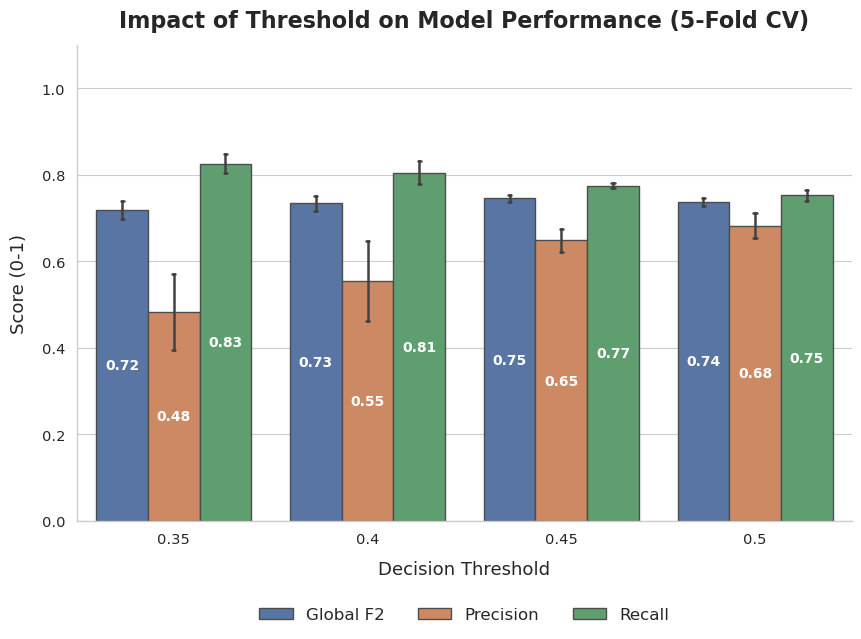

In [68]:
# 2. Konfiguracja stylu
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.figure(figsize=(10, 7))  # Nieco wyższy wykres, żeby zmieścić legendę na dole

# 3. Definicja kolorów (Manualna dla pełnej kontroli - zgodna z Twoim obrazkiem)
# Global F2 (Niebieski), Precision (Pomarańczowy), Recall (Zielony)
colors = sns.color_palette("deep", 3)

# 4. Rysowanie wykresu
ax = sns.barplot(
    data=df_metrics,
    x="Threshold",
    y="Score",
    hue="Metric",
    palette=colors,  # Używamy palety deep (jak na obrazku) zamiast viridis
    capsize=.05,  # Nieco subtelniejsze wąsy błędów
    errorbar="sd",
    edgecolor="0.3",  # Ciemnoszare obramowanie dla kontrastu
    linewidth=1
)

# 5. Tytuły i osie
plt.title('Impact of Threshold on Model Performance (5-Fold CV)', fontsize=16, weight='bold', y=1.02)
plt.xlabel('Decision Threshold', fontsize=13, labelpad=10)
plt.ylabel('Score (0-1)', fontsize=13, labelpad=10)
plt.ylim(0, 1.1)

# 6. POPRAWIONA LEGENDA (Umieszczona pod wykresem)
plt.legend(
    title=None,  # Usuwamy zbędny tytuł "Metric"
    loc='upper center',  # Punkt zaczepienia legendy
    bbox_to_anchor=(0.5, -0.15),  # Przesunięcie pod oś X
    ncol=3,  # Wszystkie elementy w jednej linii
    frameon=False,  # Bez ramki
    fontsize=12
)

# 7. Wartości na słupkach (Annotation)
for container in ax.containers:
    # Pobieramy wartości i formatujemy
    labels = [f'{v.get_height():.2f}' for v in container]

    ax.bar_label(
        container,
        labels=labels,
        label_type='center',  # Tekst w środku słupka
        padding=0,
        fontsize=10,
        color='white',  # Biały tekst
        weight='bold'  # Pogrubienie dla czytelności
    )

# Usunięcie górnej i prawej ramki
sns.despine()

# Ważne: adjust layout żeby legenda nie została ucięta przy zapisie
plt.subplots_adjust(bottom=0.2)

# Zapis
output_path = PROJECT_ROOT / "metrics_by_threshold__rf.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

## XGB Classifier

In [83]:
# XGBoost ma inne parametry niż RF.
# Kluczowy jest 'scale_pos_weight', który pomaga "wymusić" wyższy Recall (ważne dla F2).
search_spaces_xgb = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),  # Boosting woli płytsze drzewa niż RF
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),  # Zapobiega overfittingowi
    'colsample_bytree': Real(0.6, 1.0),  # Odpowiednik max_features
    'scale_pos_weight': Integer(1, 6)  # MAGIA DLA F2: Waży klasę pozytywną mocniej
}

In [69]:
# Stratified K-Fold zapewnia, że w każdym "foldzie" proporcja klas jest zachowana
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# F2
beta = 2

# Listy na wyniki
results_by_threshold = {t: {
    "val_f2": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f2": []
} for t in THRESHOLDS}

best_params_history = []

print(f"XGBClassifier: Rozpoczynam {N_FOLDS}-krotną walidację krzyżową...")
print(f"Sprawdzane progi: {THRESHOLDS}")
print(f"Wielkość próbki: {len(y_sampled)} (Trening w foldzie: ~{int(len(y_sampled) * 0.8)})")

fold_no = 1
for train_idx_local, test_idx_local in skf.split(X_sampled, y_sampled):
    # 1. Przygotowanie zbiorów
    X_train_fold = X_sampled[train_idx_local]
    y_train_fold = y_sampled[train_idx_local]
    X_test_fold = X_sampled[test_idx_local]
    y_test_fold = y_sampled[test_idx_local]

    # Maski i zbiór globalny
    global_train_indices = sample_indices[train_idx_local]
    mask_train = np.zeros(len(df_merged), dtype=bool)
    mask_train[global_train_indices] = True
    X_test_global = X_full[~mask_train]

    # 2. Hiperoptymalizacja Bayesowska
    opt = BayesSearchCV(
        estimator=XGBClassifier(
            n_jobs=-1,
            random_state=RANDOM_SEED,
            eval_metric='logloss',  # Cicha praca bez ostrzeżeń
            use_label_encoder=False
        ),
        search_spaces=search_spaces_xgb,
        scoring='f1',
        cv=3,
        n_iter=15,
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=0
    )
    opt.fit(X_train_fold, y_train_fold)
    best_model_xgb = opt.best_estimator_
    best_params_xgb = dict(opt.best_params_)
    best_params_history.append(best_params_xgb)
    print(f"\nFold {fold_no}: Params: {best_params_xgb}")

    # Obliczamy prawdopodobieństwa RAZ dla danego folda/modelu
    probs_local = best_model_xgb.predict_proba(X_test_fold)[:, 1]
    probs_global = best_model_xgb.predict_proba(X_test_global)[:, 1]

    # Przygotowanie Ground Truth do filtrowania (wspólne dla folda)
    train_positive_indices = global_train_indices[y_train_fold == 1]
    train_positive_merge_cols = df_merged.iloc[train_positive_indices]["merge_col"]
    df_res_filtered = df_res[~df_res.merge_col.isin(train_positive_merge_cols)]

    # 3. Pętla po progach (ewaluacja wielu wariantów naraz)
    best_fold_stats = {"f2_global": -1, "thr": 0, "p": 0, "r": 0, "val_f2": 0}
    for t in THRESHOLDS:
        # --- Ewaluacja Lokalna (Walidacja) ---
        preds_local_t = (probs_local >= t).astype(int)
        val_f2 = fbeta_score(y_test_fold, preds_local_t, beta=2, zero_division=0)
        val_acc = accuracy_score(y_test_fold, preds_local_t)

        # --- Ewaluacja Globalna (Reszta Świata) ---
        val_preds_global = (probs_global >= t).astype(int)

        # Logika biznesowa (Set-based metrics)
        df_test_fold = df_merged[~mask_train].copy()
        df_test_fold["result"] = val_preds_global

        res_filt = df_test_fold[df_test_fold["result"] == 1]
        org_set = set(df_res_filtered[["plLabel", "alias"]].itertuples(index=False, name=None))
        new_set = set(res_filt[["plLabel", "alias"]].itertuples(index=False, name=None))

        true_positive_count = len(new_set & org_set)
        false_positive_count = len(new_set - org_set)
        false_negative_df = df_res_filtered.loc[~df_res_filtered["index"].isin(res_filt["index"])]
        false_negative_count = len(false_negative_df)

        prec = true_positive_count / (true_positive_count + false_positive_count) if (
                                                                                             true_positive_count + false_positive_count) > 0 else 0
        rec = true_positive_count / (true_positive_count + false_negative_count) if (
                                                                                            true_positive_count + false_negative_count) > 0 else 0
        f2_global = (1 + beta ** 2) * (prec * rec) / (beta ** 2 * prec + rec) if (beta ** 2 * prec + rec) > 0 else 0

        # Zapis do słownika wyników dla danego progu
        results_by_threshold[t]["val_f2"].append(val_f2)
        results_by_threshold[t]["accuracy"].append(val_acc)
        results_by_threshold[t]["precision"].append(prec)
        results_by_threshold[t]["recall"].append(rec)
        results_by_threshold[t]["f2"].append(f2_global)

        # --- Aktualizacja najlepszego wyniku w tym foldzie ---
        if f2_global > best_fold_stats["f2_global"]:
            best_fold_stats = {
                "f2_global": f2_global,
                "thr": t,
                "p": prec,
                "r": rec,
                "val_f2": val_f2
            }

    # Print per fold
    print(
        f"Fold {fold_no}: Best Thr: {best_fold_stats['thr']:.2f} | Val F2: {best_fold_stats['val_f2']:.4f} | Global F2: {best_fold_stats['f2_global']:.4f} (P: {best_fold_stats['p']:.2f}, R: {best_fold_stats['r']:.2f})")
    fold_no += 1

# XGBClassifier: Rozpoczynam 5-krotną walidację krzyżową...
# Sprawdzane progi: [0.35, 0.4, 0.45, 0.5]
# Wielkość próbki: 1250 (Trening w foldzie: ~1000)
#
# Fold 1: Params: {'colsample_bytree': 0.9144697718580344, 'learning_rate': 0.01766015942605312, 'max_depth': 4, 'n_estimators': 304, 'scale_pos_weight': 1, 'subsample': 0.8951010536148178}
# Fold 1: Best Thr: 0.40 | Val F2: 0.8962 | Global F2: 0.7538 (P: 0.64, R: 0.79)
#
# Fold 2: Params: {'colsample_bytree': 0.9943133914706446, 'learning_rate': 0.026778228634488185, 'max_depth': 9, 'n_estimators': 314, 'scale_pos_weight': 1, 'subsample': 0.6153560777912817}
# Fold 2: Best Thr: 0.40 | Val F2: 0.8533 | Global F2: 0.7523 (P: 0.66, R: 0.78)
#
# Fold 3: Params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 409, 'scale_pos_weight': 1, 'subsample': 0.6631156349653888}
# Fold 3: Best Thr: 0.45 | Val F2: 0.9034 | Global F2: 0.7476 (P: 0.66, R: 0.77)
#
# Fold 4: Params: {'colsample_bytree': 0.9420628376522001, 'learning_rate': 0.01076466477702899, 'max_depth': 3, 'n_estimators': 445, 'scale_pos_weight': 1, 'subsample': 0.9353601386651003}
# Fold 4: Best Thr: 0.45 | Val F2: 0.8643 | Global F2: 0.7389 (P: 0.67, R: 0.76)
#
# Fold 5: Params: {'colsample_bytree': 0.9762987187701567, 'learning_rate': 0.017431482235144007, 'max_depth': 3, 'n_estimators': 331, 'scale_pos_weight': 1, 'subsample': 0.6859076555146111}
# Fold 5: Best Thr: 0.40 | Val F2: 0.8758 | Global F2: 0.7403 (P: 0.57, R: 0.80)


XGBClassifier: Rozpoczynam 5-krotną walidację krzyżową...
Sprawdzane progi: [0.35, 0.4, 0.45, 0.5]
Wielkość próbki: 1250 (Trening w foldzie: ~1000)

Fold 1: Params: {'colsample_bytree': 0.9144697718580344, 'learning_rate': 0.01766015942605312, 'max_depth': 4, 'n_estimators': 304, 'scale_pos_weight': 1, 'subsample': 0.8951010536148178}
Fold 1: Best Thr: 0.40 | Val F2: 0.8962 | Global F2: 0.7538 (P: 0.64, R: 0.79)

Fold 2: Params: {'colsample_bytree': 0.9943133914706446, 'learning_rate': 0.026778228634488185, 'max_depth': 9, 'n_estimators': 314, 'scale_pos_weight': 1, 'subsample': 0.6153560777912817}
Fold 2: Best Thr: 0.40 | Val F2: 0.8533 | Global F2: 0.7523 (P: 0.66, R: 0.78)

Fold 3: Params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 409, 'scale_pos_weight': 1, 'subsample': 0.6631156349653888}
Fold 3: Best Thr: 0.45 | Val F2: 0.9034 | Global F2: 0.7476 (P: 0.66, R: 0.77)

Fold 4: Params: {'colsample_bytree': 0.9420628376522001, 'learning_rate': 0.

### Results

In [70]:
# --- PODSUMOWANIE PARAMETRÓW (Mode / Najczęstsze) ---
params_df = pd.DataFrame(best_params_history)
print("\n" + "=" * 50)
print("ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)")
print("=" * 50)
# Wyliczamy najczęściej występującą wartość dla każdego parametru
most_common_params = params_df.mode().iloc[0].to_dict()
print("Najczęstsza konfiguracja (Dominanta):")
for k, v in most_common_params.items():
    # Jeśli parametry są liczbami, formatujemy ładnie, jeśli stringi to zostawiamy
    val_str = f"{int(v)}" if isinstance(v, (int, np.integer)) else f"{v}"
    print(f"  {k}: {val_str}")

# --- PODSUMOWANIE WYNIKÓW DLA KAŻDEGO PROGU ---
# 1. Najpierw znajdujemy zwycięski próg (najwyższe średnie F2)
best_avg_f2 = -1
best_t_final = None

for t in THRESHOLDS:
    current_avg_f2 = np.mean(results_by_threshold[t]['f2'])
    if current_avg_f2 > best_avg_f2:
        best_avg_f2 = current_avg_f2
        best_t_final = t

# 2. Wyświetlamy wyniki, oznaczając zwycięzcę w nagłówku
for t in THRESHOLDS:
    res = results_by_threshold[t]

    # Sprawdzamy czy to zwycięzca
    if t == best_t_final:
        header_suffix = " 🏆 "
    else:
        header_suffix = ""

    print(f"\n=== {header_suffix} WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: {t:.2f} ===")
    print(f"Val F2 (Local): {np.mean(res['val_f2']):.4f} ± {np.std(res['val_f2']):.4f}")
    print(f"Accuracy (Val): {np.mean(res['accuracy']):.4f} ± {np.std(res['accuracy']):.4f}")
    print("-" * 40)
    print(f"Precision:      {np.mean(res['precision']):.4f} ± {np.std(res['precision']):.4f}")
    print(f"Recall:         {np.mean(res['recall']):.4f} ± {np.std(res['recall']):.4f}")
    print(f"F2-Score:       {np.mean(res['f2']):.4f} ± {np.std(res['f2']):.4f}")

# precision: 0.6469689849624061
# recall: 0.7762898223851141
# F2: 0.7464487096074605
# próg: 0.4


ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)
Najczęstsza konfiguracja (Dominanta):
  colsample_bytree: 0.6
  learning_rate: 0.01
  max_depth: 3.0
  n_estimators: 304.0
  scale_pos_weight: 1.0
  subsample: 0.6153560777912817

===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.35 ===
Val F2 (Local): 0.8941 ± 0.0216
Accuracy (Val): 0.8512 ± 0.0122
----------------------------------------
Precision:      0.4934 ± 0.0684
Recall:         0.8225 ± 0.0180
F2-Score:       0.7222 ± 0.0140

===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.40 ===
Val F2 (Local): 0.8821 ± 0.0169
Accuracy (Val): 0.8600 ± 0.0084
----------------------------------------
Precision:      0.5971 ± 0.0572
Recall:         0.7940 ± 0.0125
F2-Score:       0.7431 ± 0.0106

===  🏆  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.45 ===
Val F2 (Local): 0.8710 ± 0.0267
Accuracy (Val): 0.8640 ± 0.0136
----------------------------------------
Precision:      0.6562 ± 0.0252
Recall:         0.7702 ± 0.0084
F2-Score

In [ ]:
# ==================================================
# ANALIZA HIPERPARAMETRÓW (Best Params z 5 foldów)
# ==================================================
# Najczęstsza konfiguracja (Dominanta):
#   colsample_bytree: 0.6
#   learning_rate: 0.01
#   max_depth: 3.0
#   n_estimators: 304.0
#   scale_pos_weight: 1.0
#   subsample: 0.6153560777912817
#
# ===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.35 ===
# Val F2 (Local): 0.8941 ± 0.0216
# Accuracy (Val): 0.8512 ± 0.0122
# ----------------------------------------
# Precision:      0.4934 ± 0.0684
# Recall:         0.8225 ± 0.0180
# F2-Score:       0.7222 ± 0.0140
#
# ===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.40 ===
# Val F2 (Local): 0.8821 ± 0.0169
# Accuracy (Val): 0.8600 ± 0.0084
# ----------------------------------------
# Precision:      0.5971 ± 0.0572
# Recall:         0.7940 ± 0.0125
# F2-Score:       0.7431 ± 0.0106
#
# ===  🏆  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.45 ===
# Val F2 (Local): 0.8710 ± 0.0267
# Accuracy (Val): 0.8640 ± 0.0136
# ----------------------------------------
# Precision:      0.6562 ± 0.0252
# Recall:         0.7702 ± 0.0084
# F2-Score:       0.7441 ± 0.0064
#
# ===  WYNIKI KOŃCOWE (Średnia +/- Std) dla Threshold: 0.50 ===
# Val F2 (Local): 0.8651 ± 0.0235
# Accuracy (Val): 0.8648 ± 0.0159
# ----------------------------------------
# Precision:      0.6823 ± 0.0112
# Recall:         0.7580 ± 0.0104
# F2-Score:       0.7415 ± 0.0066

### Plot

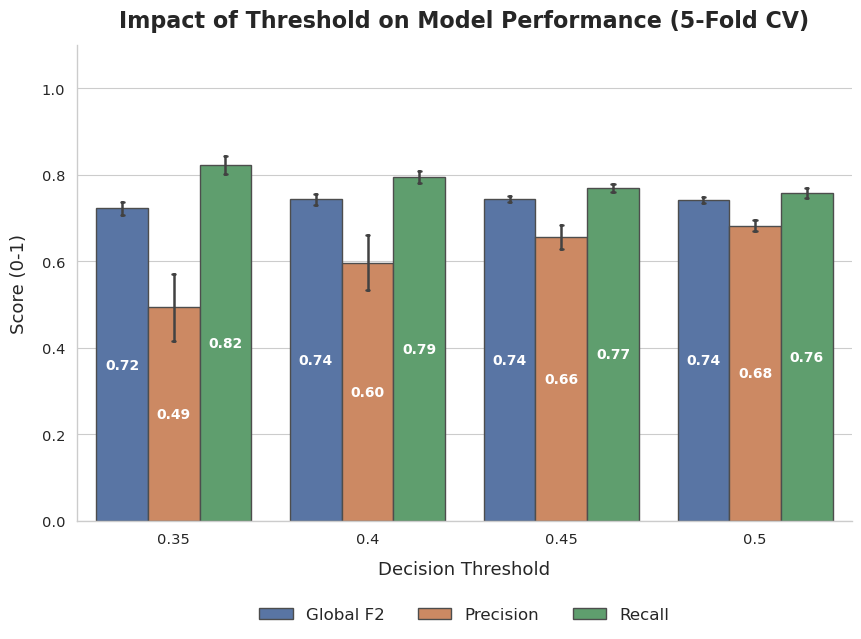

In [71]:
# 1. Konwersja zagnieżdżonego słownika results_by_threshold do płaskiego DataFrame
data_rows = []

for t, metrics in results_by_threshold.items():
    # metrics to słownik z listami np. [0.7, 0.72, ...] dla każdego folda
    n_folds_actual = len(metrics['f2'])  # powinno być 5

    for i in range(n_folds_actual):
        # Dodajemy wiersze dla każdej metryki, która nas interesuje
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Global F2', 'Score': metrics['f2'][i]})
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Precision', 'Score': metrics['precision'][i]})
        data_rows.append({'Threshold': t, 'Fold': i + 1, 'Metric': 'Recall', 'Score': metrics['recall'][i]})
        # Opcjonalnie dodaj Val F2 jeśli chcesz porównać
        # data_rows.append({'Threshold': t, 'Fold': i+1, 'Metric': 'Local Val F2', 'Score': metrics['val_f2'][i]})

df_metrics = pd.DataFrame(data_rows)

# Sprawdźmy jak to wygląda
# df_metrics

# 2. Konfiguracja stylu
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.figure(figsize=(10, 7))  # Nieco wyższy wykres, żeby zmieścić legendę na dole

# 3. Definicja kolorów (Manualna dla pełnej kontroli - zgodna z Twoim obrazkiem)
# Global F2 (Niebieski), Precision (Pomarańczowy), Recall (Zielony)
colors = sns.color_palette("deep", 3)

# 4. Rysowanie wykresu
ax = sns.barplot(
    data=df_metrics,
    x="Threshold",
    y="Score",
    hue="Metric",
    palette=colors,  # Używamy palety deep (jak na obrazku) zamiast viridis
    capsize=.05,  # Nieco subtelniejsze wąsy błędów
    errorbar="sd",
    edgecolor="0.3",  # Ciemnoszare obramowanie dla kontrastu
    linewidth=1
)

# 5. Tytuły i osie
plt.title('Impact of Threshold on Model Performance (5-Fold CV)', fontsize=16, weight='bold', y=1.02)
plt.xlabel('Decision Threshold', fontsize=13, labelpad=10)
plt.ylabel('Score (0-1)', fontsize=13, labelpad=10)
plt.ylim(0, 1.1)

# 6. POPRAWIONA LEGENDA (Umieszczona pod wykresem)
plt.legend(
    title=None,  # Usuwamy zbędny tytuł "Metric"
    loc='upper center',  # Punkt zaczepienia legendy
    bbox_to_anchor=(0.5, -0.15),  # Przesunięcie pod oś X
    ncol=3,  # Wszystkie elementy w jednej linii
    frameon=False,  # Bez ramki
    fontsize=12
)

# 7. Wartości na słupkach (Annotation)
for container in ax.containers:
    # Pobieramy wartości i formatujemy
    labels = [f'{v.get_height():.2f}' for v in container]

    ax.bar_label(
        container,
        labels=labels,
        label_type='center',  # Tekst w środku słupka
        padding=0,
        fontsize=10,
        color='white',  # Biały tekst
        weight='bold'  # Pogrubienie dla czytelności
    )

# Usunięcie górnej i prawej ramki
sns.despine()

# Ważne: adjust layout żeby legenda nie została ucięta przy zapisie
plt.subplots_adjust(bottom=0.2)

# Zapis
output_path = PROJECT_ROOT / "metrics_by_threshold__xgb.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

# ROC

In [86]:
def plot_roc_curve(
        model: RandomForestClassifier,
        X: np.ndarray,
        y: np.ndarray,
        title: str = "ROC curve (Random Forest)",
        save_path: Path | None = None,
        mark_threshold: float | None = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Plot ROC curve for a binary classifier and optionally save to file.

    Returns fpr, tpr, thresholds, auc_value.
    """
    proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, proba)
    auc_value = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(4.0, 4.0), dpi=300)

    # ROC curve
    ax.plot(fpr, tpr, lw=1.8, label=f"AUC = {auc_value:.3f}")

    # Diagonal (random classifier)
    ax.plot([0.0, 1.0], [0.0, 1.0], "--", lw=1.0, label="Random")

    # Optional: mark chosen operating point (e.g. best_t_final = 0.45)
    if mark_threshold is not None:
        idx = np.argmin(np.abs(thresholds - mark_threshold))
        ax.scatter(
            fpr[idx],
            tpr[idx],
            s=25,
            marker="o",
            zorder=3,
            label=f"Threshold = {mark_threshold:.2f}",
        )

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.02)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.set_title(title)
    ax.set_aspect("equal", "box")
    ax.grid(True, linestyle=":", linewidth=0.5)
    ax.legend(loc="lower right", frameon=True)

    fig.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
        plt.close(fig)

    return fpr, tpr, thresholds, auc_value


## RF

In [88]:
best_model_rf

RandomForestClassifier(max_depth=25, min_samples_leaf=6, min_samples_split=16,
                       n_estimators=571, n_jobs=-1, random_state=42)

In [89]:
best_params_rf

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 16,
 'n_estimators': 571}

In [91]:
fig_path = PROJECT_ROOT / "figures" / "roc_rf_similarity.pdf"

# jeżeli chcesz zaznaczyć próg wybrany z wcześniejszej analizy:
best_t_final = 0.45  # albo to, co wyszło z Twojego kodu

fpr, tpr, thresholds, auc_value = plot_roc_curve(
    model=best_model_rf,
    X=X_sampled,
    y=y_sampled,
    title="Random Forest - ROC curve",
    save_path=fig_path,
    mark_threshold=best_t_final,
)

print(f"AUC: {auc_value:.3f}")
print(f"Wykres zapisany do: {fig_path}")

AUC: 0.937
Wykres zapisany do: lvm-ner/figures/roc_rf_similarity.pdf


## XGB

In [76]:
best_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9762987187701567, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.017431482235144007,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=331, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [78]:
best_params_xgb

{'colsample_bytree': 0.9762987187701567,
 'learning_rate': 0.017431482235144007,
 'max_depth': 3,
 'n_estimators': 331,
 'scale_pos_weight': 1,
 'subsample': 0.6859076555146111}

In [92]:
fig_path = PROJECT_ROOT / "figures" / "roc_xgb_similarity.pdf"

# jeżeli chcesz zaznaczyć próg wybrany z wcześniejszej analizy:
best_t_final = 0.45  # albo to, co wyszło z Twojego kodu

fpr, tpr, thresholds, auc_value = plot_roc_curve(
    model=best_model_xgb,
    X=X_sampled,
    y=y_sampled,
    title="XGBoost - ROC curve",
    save_path=fig_path,
    mark_threshold=best_t_final,
)

print(f"AUC: {auc_value:.3f}")
print(f"Wykres zapisany do: {fig_path}")

AUC: 0.941
Wykres zapisany do: lvm-ner/figures/roc_xgb_similarity.pdf


# END